In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    plot_thresh_to_acc, age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test, deconfound,
)

/tmp/ipykernel_67703/1876315637.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# TODO: 
# mail denis
# mail joschka
# check offdiagonal age sources gap
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?
# accept a thresh as input (valid for eval)

In [4]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [6]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence, cv
#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval

#exp = '2023-02-01T14:42:53.219167' # TCN exluding recs with age divergence, subject-wise cv
exp_dir = os.path.join(base_dir, exp)

In [7]:
configs = read_result(exp_dir, 'config')

In [8]:
configs

,augment,batch_size,data_path,date,debug,fast_mode,final_eval,intuitive_training_scores,loss,max_age,...,squash_outs,standardize_data,standardize_targets,subset,target_name,tmin,tmax,valid_set_i,window_size_samples,run_name
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age


In [9]:
assert configs['final_eval'].nunique() == 1

In [10]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed']]

,model_name,target_name,valid_set_i,seed
0,tcn,age,0,20220429
0,tcn,age,0,20221017
0,tcn,age,0,20221018
0,tcn,age,0,20221019
0,tcn,age,0,20221020


In [11]:
scores = read_result(exp_dir, 'score')

In [12]:
if (configs['final_eval'] == '1').all():
    display(scores.loc[['mae']].mean())
else:
    display(scores.loc[['mae']].groupby('seed').mean())

train               2.585682e+00
eval                6.369889e+00
valid_not_normal    1.064924e+01
seed                2.022090e+07
valid_set_i         0.000000e+00
dtype: float64

In [13]:
histories = read_result(exp_dir, 'history')

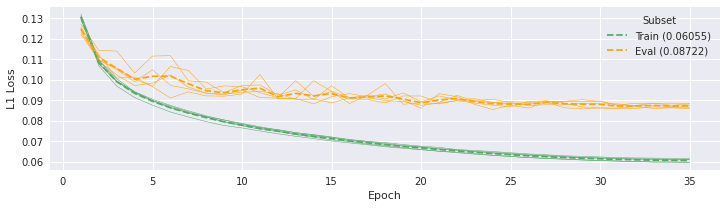

In [14]:
if (configs['final_eval'] == '1').all():
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], 'L1 Loss', 'Eval')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], 'L1 Loss')
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')

In [15]:
preds = read_result(exp_dir, 'preds')

In [16]:
accs = []
for n1, g1 in preds.groupby('seed'):
    acc = balanced_accuracy_score(g1.y_true.to_numpy().astype(int), g1.y_pred.to_numpy().astype(int))
    accs.append(acc)
mean_acc = np.mean(accs)
print(f'avg acc over {preds.seed.nunique()} seeds with {preds.valid_set_i.nunique()} folds', mean_acc)

avg acc over 5 seeds with 1 folds 0.025507621033936823


TODO: automatically find y_lim  
TODO: always plot subject_wise?

In [17]:
def heatmaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)]
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
        g1 = deconfound(g1, detrend)
        ax = plot_heatmaps(g1, bin_width, 100, 12)
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = g1[g1.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            g1 = deconfound(g1, detrend)
            ax = plot_heatmaps(g1, bin_width, 100, 100)
    return ax

In [18]:
def gaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
        g1 = deconfound(g1, detrend)
        ax = plot_age_gap_hist_and_permutation_test(
            g1, bin_width, n_repetitions,
        )
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = preds[preds.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            g1 = deconfound(g1, detrend)
            ax = plot_age_gap_hist_and_permutation_test(
                g1, bin_width, n_repetitions,
            )
    return ax

In [19]:
def proxy(preds, configs, sex, min_age, max_age, cols, detrend, bin_width, thresh1=None, thresh2=None):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
        g1 = deconfound(g1, detrend)
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            g1, bin_width, n_repetitions, thresh1, thresh2,
        )
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = preds[preds.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            g1 = deconfound(g1, detrend)
            ax = plot_age_gap_hist_with_thresh_and_permutation_test(
                g1, bin_width, n_repetitions,
            )
    return ax

In [20]:
bin_width = 2
n_repetitions = 100000  # ! actually 100000 !
cols = ['y_pred', 'y_true', 'pathological', 'subject', 'index', 'subset']

In [21]:
age_limits = [(None, None)]#, (None, 30), (30, 60), (60, None)]
sexes = [None]#, 'F', 'M']
detrends = ['quadratic']  # None, linear, quadratic
# extracted from cv
thresh1 = -10.713935004717143 if (configs['final_eval'] == '1').all() else None 
thresh2 = 5.154135050425772 if (configs['final_eval'] == '1').all() else None

12 86 None quadratic -10.713935004717143 5.154135050425772
observed age gap diff 2.118479728632363
given thresholds -10.713935004717143 5.154135050425772
observed score 61.88328321639381


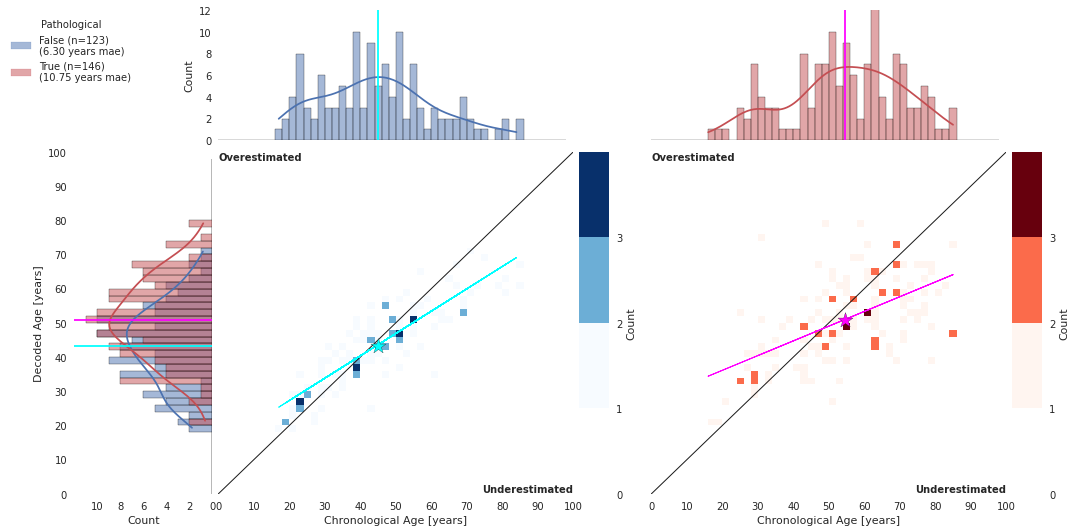

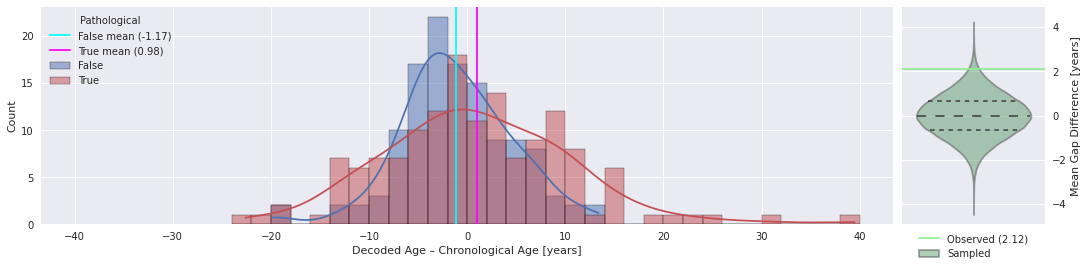

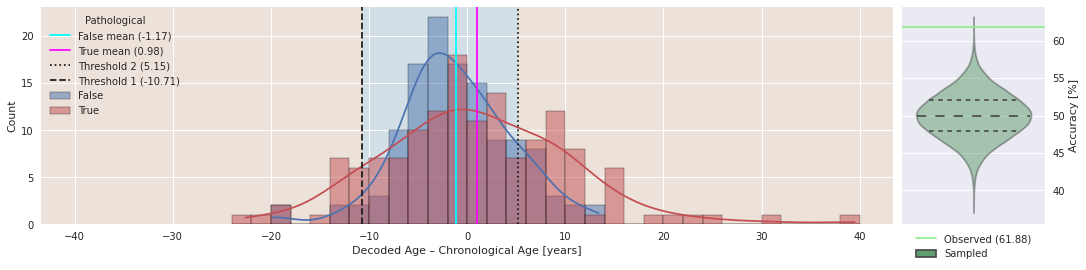

In [22]:
for (min_age, max_age) in age_limits:
    for sex in sexes:
        for detrend in detrends:
            max_age = preds.age.max() if max_age is None else max_age
            min_age = preds.age.min() if min_age is None else min_age
            print(min_age, max_age, sex, detrend, thresh1, thresh2)
            # actual predictions can never be detrended as this would be cheating
            ax = heatmaps(preds, configs, sex, min_age, max_age, cols, None, bin_width)
            ax.get_figure().savefig('/home/jovyan/eval_heatmaps.jpg', bbox_inches='tight', dpi=300)
            ax = gaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width)
            ax.get_figure().savefig('/home/jovyan/eval_gaps.jpg', bbox_inches='tight', dpi=300)
            ax = proxy(preds, configs, sex, min_age, max_age, cols, detrend, bin_width, thresh1, thresh2)
            ax.get_figure().savefig('/home/jovyan/eval_proxy.jpg', bbox_inches='tight', dpi=300)

In [32]:
# train detrend effect?